# Spike Train
A variation of SpikeNet, using SNNs and other brain inspired computing techniques to conduct GNN machine learning. 

## Aim
- The aim is to transform the original representation of nodes, which is usually a float vector, into a a spike train, which is essentially a binary vector
- These spike sequences become the node representation and are used in practical applications such as paper citation networks, recommender systems, and protein analysis
- This spike train is obtained using SNNs, where each feature in each node has a LIF neuron that accumulates charge and fires once it is past a certain threshold
- We want our model to also be able to adapt to dynamic graphs, and so we design to regenerate the spikes only when necessary

## Technical details
### 1: Data loading
- Can use the dataset class that already exists to load
- Data is in the shape: (time_step, num_nodes, num_features)
  
### 2: Spike train generation
- For each time step, use the provided formula to get the new potential
- [Future] To only calculate this for nodes that face significant changes

### 3: Concat the final spike train and do ML tasks with it
- [Future] Figure out some kind of further ML algorithms to gain meaningful results

## Code
## 1: Data loading and exploration
### Import libraries and dataset

In [1]:
import argparse
import time

import torch
import torch.nn as nn
from sklearn import metrics
from torch.utils.data import DataLoader
from tqdm import tqdm

from spikenet import dataset, neuron
from spikenet.layers import SAGEAggregator
from spikenet.utils import (RandomWalkSampler, Sampler, add_selfloops,
                            set_seed, tab_printer)
import scipy.sparse as sp

from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

def printline():
  print("="*80)

In [2]:
data = dataset.DBLP()

/Users/zhekailow/Documents/University/FYP/code/SpikeNet/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/zhekailow/Documents/University/FYP/code/SpikeNet/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


### Basic information about the data

x information:
Time steps - 27
Nodes - 28085
Num features - 128
y information:
Nodes - 28085
Num unique classes - 10


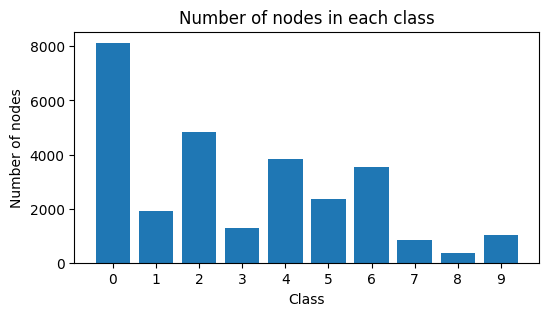

In [3]:
print(f"x information:\nTime steps - {data.x.shape[0]}\nNodes - {data.x.shape[1]}\nNum features - {data.x.shape[2]}")
printline()
print(f"y information:\nNodes - {data.y.shape[0]}\nNum unique classes - {data.num_classes}")

# Plot a histogram of the number of nodes in each class
unique_vals = defaultdict(int)
for label in data.y:
  unique_vals[label.item()] += 1
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(unique_vals.keys(), unique_vals.values())
ax.set_xlabel("Class")
ax.set_xticks(range(len(unique_vals)))
ax.set_ylabel("Number of nodes")
ax.set_title("Number of nodes in each class")
plt.show()

In [4]:
data.y.shape

torch.Size([28085])

adj len: 27
adj shape: (28085, 28085)
adj_evolve len: 27
adj_evolve shape: (28085, 28085)
edges len: 27
edges shape: torch.Size([2, 856])


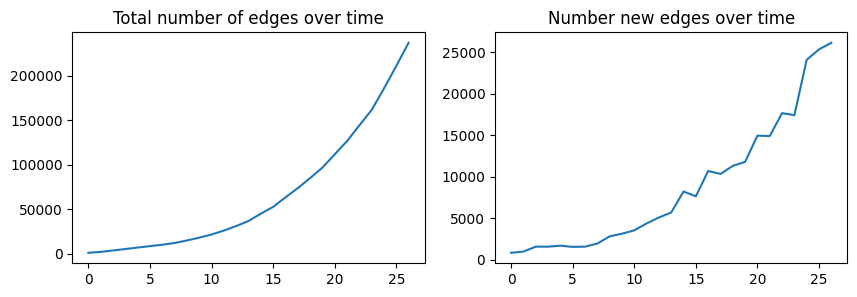

In [5]:
print(f"adj len: {len(data.adj)}\nadj shape: {data.adj[0].shape}")
printline()
print(f"adj_evolve len: {len(data.adj_evolve)}\nadj_evolve shape: {data.adj_evolve[0].shape}")
printline()
print(f"edges len: {len(data.edges)}\nedges shape: {data.edges[0].shape}")

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Plot the number of edges over time
num_edges = []
for i in range(len(data.edges)):
  num_edges.append(int(data.edges[i].shape[1]))
ax[0].plot(num_edges)
ax[0].set_title("Total number of edges over time")

# Plot the number of edges_evolve over time
num_edges_evolve = []
for i in range(len(data.edges_evolve)):
  num_edges_evolve.append(int(data.edges_evolve[i].shape[1]))
ax[1].plot(num_edges_evolve)
ax[1].set_title("Number new edges over time")
plt.show()

In [6]:
# Show the degree array
degree = data.degree
print(f"degree len: {len(degree)}\ndegree shape: {degree[0].shape}")
for i in range(20):
  print(f"Time step {i}: {degree[i][:10]}")

degree len: 27
degree shape: (28085,)
Time step 0: [0 0 0 0 0 0 0 0 0 0]
Time step 1: [0 0 0 0 0 0 0 0 0 0]
Time step 2: [0 0 0 0 0 0 0 0 1 0]
Time step 3: [0 0 0 0 0 0 0 0 1 0]
Time step 4: [0 0 0 1 0 0 0 0 1 0]
Time step 5: [0 0 0 1 0 0 0 0 1 0]
Time step 6: [0 0 0 1 0 0 0 0 1 0]
Time step 7: [0 0 0 1 0 0 0 0 1 0]
Time step 8: [0 0 1 1 0 0 0 0 1 1]
Time step 9: [0 0 1 3 0 0 0 0 1 1]
Time step 10: [0 0 1 7 0 0 0 0 2 2]
Time step 11: [0 0 1 9 0 0 0 0 2 3]
Time step 12: [0 0 1 9 0 0 0 0 2 3]
Time step 13: [0 0 1 9 0 0 0 0 2 5]
Time step 14: [ 0  0  5 18  0  0  0  0  2  7]
Time step 15: [ 0  0  5 24  0  0  0  0 10  8]
Time step 16: [ 5  0  6 24  0  0  0  0 21  9]
Time step 17: [ 5  0  7 24  0  0  0  0 23  9]
Time step 18: [ 5  0 11 24  0  0  0  0 24  9]
Time step 19: [ 7  0 19 24  0  1  0  0 24 11]


## 2: Spike train generation


In [7]:
tau = 1.0
alpha = 1.0
surrogate = "triangle"

snn = neuron.LIF(tau, alpha=alpha, surrogate=surrogate)

# Test some inputs
for i in range(10):
  inputs = torch.randn(10, 5)
  print(
    f"Output {i}:\n{snn(inputs)}\n"
  )

Output 0:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

Output 1:
tensor([[1., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

Output 2:
tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

Output 3:
tensor([[0., 1., 0., 0., 1.],
        [1., 0., 0., 1.,

In [8]:
def calculate_DAD_x(adj, x, a=0.5, b=0.5):
    # Get the degree matrix (D) as a vector
    degree = np.array(adj.sum(1)).flatten()
    D_inv_a = np.power(degree, -a, where=degree!=0)
    D_inv_b = np.power(degree, -b, where=degree!=0)
    
    # Convert to a sparse matrix form
    D_inv_a = sp.diags(D_inv_a)
    D_inv_b = sp.diags(D_inv_b)
    
    # Calculate (D^-a A D^-b) * x
    transformed_x = D_inv_a @ adj @ D_inv_b @ x
    return torch.FloatTensor(transformed_x)

DADx = []
for adj, x in zip(data.adj, data.x):
  DADx.append(calculate_DAD_x(adj, x))
DADx = torch.stack(DADx)
print(f"DADx shape: {DADx.shape}")

# Print some elements from the DADx tensor
for i in range(5):
  print(f"Time step {i}:\n{DADx[i, :5, :5]}")

DADx shape: torch.Size([27, 28085, 128])
Time step 0:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Time step 1:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Time step 2:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Time step 3:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Time step 4:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3027,  0.9415, -3.9845, -3.9539,  6.7597],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


In [9]:
snn = neuron.LIF(tau, alpha=alpha, surrogate=surrogate)

# Run on the DADx tensor
outputs = []
for i in range(DADx.shape[0]):
  outputs.append(snn(DADx[i]))
outputs = torch.stack(outputs)
print(f"Output shape: {outputs.shape}")

# Print the number of spikes for each time step
for i in range(27):
  print(f"Time step {i}: {torch.sum(outputs[i])}")

Output shape: torch.Size([27, 28085, 128])
Time step 0: 41907.0
Time step 1: 69681.0
Time step 2: 104373.0
Time step 3: 140384.0
Time step 4: 158714.0
Time step 5: 189567.0
Time step 6: 232498.0
Time step 7: 220877.0
Time step 8: 276628.0
Time step 9: 326976.0
Time step 10: 383512.0
Time step 11: 438530.0
Time step 12: 472890.0
Time step 13: 515275.0
Time step 14: 637637.0
Time step 15: 630916.0
Time step 16: 740108.0
Time step 17: 787209.0
Time step 18: 852996.0
Time step 19: 885669.0
Time step 20: 987899.0
Time step 21: 1038749.0
Time step 22: 1114806.0
Time step 23: 1185130.0
Time step 24: 1233335.0
Time step 25: 1296204.0
Time step 26: 1318125.0


In [10]:
# Right now I have a torch tensor of dimensions [27, 28085, 128]
# I want to combine the time axis (dim 0) with the node axis (dim 1) to get a tensor of shape [28085, 27*128]

# Reshape the tensor
spike_train = outputs.permute(1, 0, 2)
# outputs = outputs.reshape(outputs.shape[0], -1)
print(f"Output shape: {spike_train.shape}")

spike_train[0][0]

y = data.y

Output shape: torch.Size([28085, 27, 128])


### 3: Do predictions with the spike train

Using a LSTM based neural network.

Using device: cpu
Epoch [1/20], Loss: 1.1689
Accuracy on test set: 63.45%

Epoch [2/20], Loss: 0.9375
Accuracy on test set: 67.06%

Epoch [3/20], Loss: 0.8504
Accuracy on test set: 68.76%

Epoch [4/20], Loss: 0.7717
Accuracy on test set: 70.66%

Epoch [5/20], Loss: 0.7032
Accuracy on test set: 71.80%

Epoch [6/20], Loss: 0.6375
Accuracy on test set: 72.55%

Epoch [7/20], Loss: 0.5624
Accuracy on test set: 73.19%

Epoch [8/20], Loss: 0.4907
Accuracy on test set: 73.22%

Epoch [9/20], Loss: 0.4112
Accuracy on test set: 72.55%

Epoch [10/20], Loss: 0.3392
Accuracy on test set: 72.57%

Epoch [11/20], Loss: 0.2578
Accuracy on test set: 73.03%

Epoch [12/20], Loss: 0.2111
Accuracy on test set: 72.71%

Epoch [13/20], Loss: 0.1583
Accuracy on test set: 72.94%

Epoch [14/20], Loss: 0.1250
Accuracy on test set: 73.08%

Epoch [15/20], Loss: 0.1040
Accuracy on test set: 72.67%

Epoch [16/20], Loss: 0.0913
Accuracy on test set: 73.31%

Epoch [17/20], Loss: 0.0786
Accuracy on test set: 73.08%

Epoch

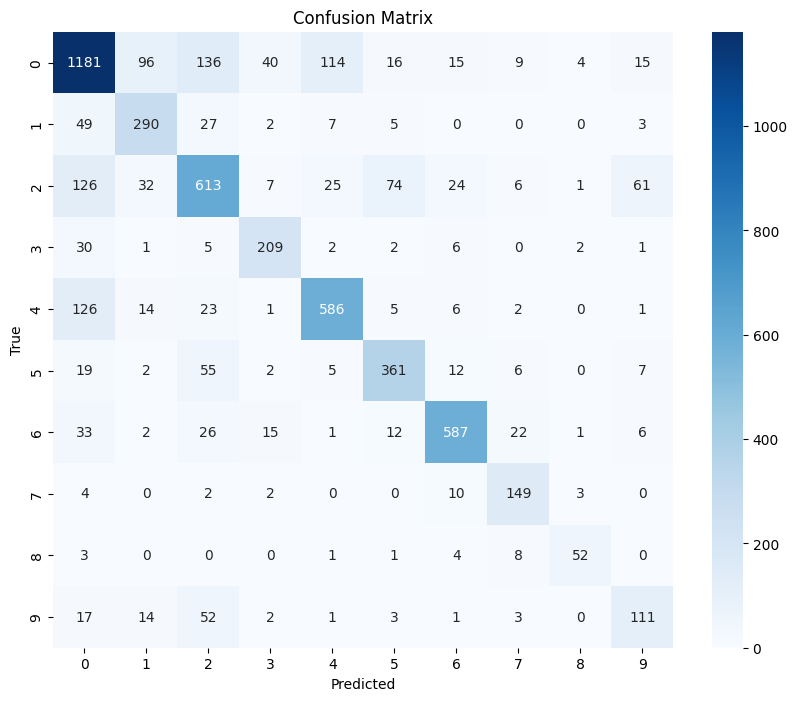

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    spike_train, y, test_size=0.2, random_state=42, stratify=y)

# Create a Custom Dataset Class
class SpikeTrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.float()  # Ensure inputs are float tensors
        self.y = y.long()   # Ensure labels are long tensors

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64

train_dataset = SpikeTrainDataset(X_train, y_train)
test_dataset = SpikeTrainDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM-Based Model
class SpikeTrainClassifier(nn.Module):
    def __init__(self, input_size=128, hidden_size=256, num_layers=2, num_classes=10):
        super(SpikeTrainClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        # Optional: Add dropout or batch normalization layers if needed

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        out, (hn, _) = self.lstm(x)
        # hn: [num_layers, batch_size, hidden_size]
        # Take the hidden state from the last LSTM layer
        hn = hn[-1]  # [batch_size, hidden_size]
        out = self.fc(hn)
        return out

# Set Up Training Components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = SpikeTrainClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%\n')

# Evaluation: Confusion Matrix
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()